# Titanic - Experiment 09

Since the target variable is a label of either survived (1) or died (0), we need a binary classification model to help us identify which passengers survived or died the Titanic disaster.

In [1]:
# Import libraries
import os
import sys

import scipy
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.features import RadViz

import warnings

from IPython.core.interactiveshell import InteractiveShell

if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())
from Titanic.Code.DataPrep.titanic import Titanic
from Titanic.Code.DataPrep.helpers import score_impute_strategies

warnings.filterwarnings('ignore')
np.random.seed(17)
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

## 1. Read and summarize the data

In [2]:
# Read data
titanic = Titanic(name='train')
titanic.get_data()
titanic.clean_data()

In [3]:
# Summarize data
output_file = r'Titanic\Docs\DataReport\titanic_profile_ex9.html'
if not os.path.isfile(output_file):
    profile = ProfileReport(titanic.data)
    profile.to_file(output_file=output_file)
    try:
        del profile
    except:
        pass
titanic.data.head()
titanic.data.tail()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,,
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.00,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.00,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,23.45,S
890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.00,C
891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,7.75,Q


#### Initial observations
 * The 'Age' column has missing values.
 * The 'Name' column includes the title of a passenger.
    * New question: Is there a pattern of survival rate for a given or group of titles?

In [4]:
print("There are %d rows and %d columns in the dataset.\n" % titanic.data.shape)
print("The columns of the dataset are: %s\n" % ', '.join(titanic.data.columns))
titanic.dtypes_

There are 891 rows and 9 columns in the dataset.

The columns of the dataset are: Survived, Pclass, Name, Sex, Age, SibSp, Parch, Fare, Embarked



{'PassengerId': numpy.int32,
 'Survived': numpy.int32,
 'Pclass': numpy.int32,
 'Name': str,
 'Sex': CategoricalDtype(categories=['male', 'female'], ordered=None),
 'Age': numpy.float64,
 'SibSp': numpy.int32,
 'Parch': numpy.int32,
 'Ticket': str,
 'Fare': numpy.float64,
 'Cabin': str,
 'Embarked': CategoricalDtype(categories=['C', 'Q', 'S'], ordered=None)}

## 2. Identify data cleanup needed, action taken, and explanation.
 * Duplicate records
 * Unnecessary columns
 * Missing data
 * Data format

### 2.1 Duplicate records

In [5]:
print("There are %d duplicate records." % titanic.data.duplicated().sum())

There are 0 duplicate records.


### 2.2 Unnecessary columns

The 'Ticket' and 'Cabin' columns are dropped via the '.clean_data()' method.
 * 'Ticket' is an almost random mix of alphanumeric characters and no valuable pattern was found.
 * 'Cabin' has over 20% of it's values missing and imputation or record removal would add bias to our final model.

### 2.3 Missing data

['Age', 'Embarked']

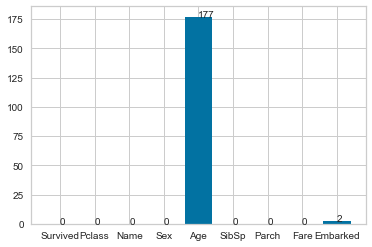

In [6]:
titanic.get_missing_columns()
titanic.plot_missing_data()

For each of 'Age' and 'Embarked': which are MCAR, MAR, or MNAR?
 * MCAR - Missing Completely at Random
    * When the probability of missing data on a variable is unrelated to any other measured variable and is unrelated to the variable with missing values itself.
         * Little's MCAR Test (abbreviated)
            1. Calculate the mean of each column with missing data.
            2. Calculate the mean of each column without missing data.
            3. If a majority of the columns have same/similar means, then it is LIKELY the data is MCAR.
         * We will perform a t-test on mean survival ('Survived') before and after removing the records with missing values.
 * MAR - Missing at Random
    * When the probability of missing data on a variable is related to some other measured variable in the model, but notto the value of the variable with missing values itself.
         * For example, when data are missing on IQ for a given threshold of age (i.e. children don't have an IQ score in the survey).
 * MNAR - Missing not at Random
    * When the missing values on a variable are related to the values of that variable itself, even after controlling for other variables.
         * For example, when data are missing on IQ and only the people with low IQ values have missing observations for this variable.

In [7]:
for col in titanic.missing_columns:
    print(col)
    if titanic.test_for_mcar(col):
        print("\tAssume equal means across samples, therefore MCAR.")
    else:
        print("\tAssume different means across samples, therefore not MCAR")
    print()

Age
	Assume equal means across samples, therefore MCAR.

Embarked
	Assume equal means across samples, therefore MCAR.



Therefore, we will operate under the assumption that both 'Age' and 'Embarked' are MCAR and imputation is a valid method for dealing with their missing values.

Python libraries we could use:
 * [statsmodels.imputation](https://www.statsmodels.org/devel/api.html#imputation)
 * [sklearn.impute](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute)
 * [fancyimpute](https://github.com/iskandr/fancyimpute)
    * [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn-impute-iterativeimputer) == MICE
 * [autoimpute](https://github.com/kearnz/autoimpute)
 * [impyute](https://github.com/eltonlaw/impyute)
 * [datawig](https://github.com/awslabs/datawig)

Relevant forum discussion links:
 * [advice-on-imputing-temperature-data-with-statsmodels-mice](https://datascience.stackexchange.com/questions/52927/advice-on-imputing-temperature-data-with-statsmodels-mice)
 * [how-to-know-which-imputation-is-best-for-impute-my-dataset-from-multiple-imputat](https://stats.stackexchange.com/questions/188288/how-to-know-which-imputation-is-best-for-impute-my-dataset-from-multiple-imputat)

Informational links on topic:
 * [Imputation and Feature Selection](https://amueller.github.io/COMS4995-s18/slides/aml-08-021218-imputation-feature-selection)
 * [Python MICE + XGBoost + Regularized Linear Models](https://www.kaggle.com/mizioan/python-mice-xgboost-regularized-linear-models)
 * [Dealing With Missing Data In Python](https://s3.amazonaws.com/assets.datacamp.com/production/course_17404/slides/chapter4.pdf)
 * [Handling Missing Values in Machine Learning: Part 1](https://archive.is/6Izzd)
 * [Handling Missing Values in Machine Learning: Part 2](http://archive.is/zY1dd)
 * [Imputing missing values with variants of IterativeImputer](https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py)

Before we start estimating imputed values and scoring them, we should encode our categorical variables.

In [8]:
titanic.encode_labels('Embarked')
titanic.encode_labels('Sex')
titanic.data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_Code,Sex_Code
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,0,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,2,1


Next, we're going to extract the passenger's title from their name and encode the resulting column
.

In [9]:
titanic.extract_title()
titanic.encode_labels('Title')
titanic.data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_Code,Sex_Code,Title,Title_Code
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,1,Mr,11
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,0,0,Mrs,12
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2,0,Miss,8
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,12
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,2,1,Mr,11


In [10]:
pd.crosstab(
    index=titanic.data['Title'], 
    columns=titanic.data['Sex']
).T.style.background_gradient()

Title,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,
male,1,2,1,6,1,0,2,40,0,0,0,517,0,0,6,1,0
female,0,0,0,1,0,1,0,0,182,2,1,0,125,1,0,0,1


In [11]:
pd.crosstab(
    index=titanic.data['Title'], 
    columns=titanic.data['Sex'], 
    values=titanic.data['Age'], 
    aggfunc=np.mean
).style.background_gradient()

Sex,male,female
Title,,
Capt,70,nan
Col,58,nan
Don,40,nan
Dr,40.6,49
Jonkheer,38,nan
Lady,nan,48
Major,48.5,nan
Master,4.57417,nan
Miss,nan,21.774


Now, we will iterate over a handful of estimators for imputation strategies and score the results of each.

In [12]:
columns = titanic.data.select_dtypes('number').columns.tolist()

scorers = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
simple_strats = ['mean', 'median']

estimators = [
    BayesianRidge(), 
    DecisionTreeRegressor(max_features='sqrt'), 
    ExtraTreesRegressor(n_estimators=10), 
    KNeighborsRegressor(n_neighbors=15)
]

for scorer in scorers:
    try:
        results = score_impute_strategies(
            data=titanic.data,
            imp_target='Age',
            columns=columns,
            scorer=scorer,
            n_splits=20,
            max_iter=20,
            simple_strats=simple_strats,
            estimators=estimators
        )
        print(scorer)
        print(results.mean())
        print()
    except ValueError:
        pass

r2
Original          Full Data                0.359597
SimpleImputer     mean                     0.371149
                  median                   0.359278
IterativeImputer  BayesianRidge            0.352831
                  DecisionTreeRegressor    0.374572
                  ExtraTreesRegressor      0.379538
                  KNeighborsRegressor      0.360529
dtype: float64

neg_mean_squared_error
Original          Full Data               -0.147175
SimpleImputer     mean                    -0.144647
                  median                  -0.145444
IterativeImputer  BayesianRidge           -0.144462
                  DecisionTreeRegressor   -0.144370
                  ExtraTreesRegressor     -0.145426
                  KNeighborsRegressor     -0.145082
dtype: float64

neg_mean_absolute_error
Original          Full Data               -0.303079
SimpleImputer     mean                    -0.296553
                  median                  -0.297176
IterativeImputer  BayesianRidge   

Based on these results, we'll go with a DecisionTreeRegressor model to impute values for 'Age'.

In [13]:
columns = titanic.data.select_dtypes('number').columns.tolist()
estimator = DecisionTreeRegressor(max_features='sqrt')
max_iter = 20
titanic.impute_values(
    estimator=estimator,
    column='Age',
    columns=columns,
    max_iter=max_iter
)
titanic.data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_Code,Sex_Code,Title,Title_Code,Age_Impute
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,1,Mr,11,22.0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,0,0,Mrs,12,38.0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2,0,Miss,8,26.0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,12,35.0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,2,1,Mr,11,35.0


Next, we need to find a valid strategy for imputing missing values in the 'Embarked' column.

In [14]:
columns = titanic.data.select_dtypes('number').columns.tolist()
columns.remove('Age_Impute')
columns.remove('Age')

simple_strats = ['most_frequent']
estimators = [
    LogisticRegression(multi_class='auto'), 
    DecisionTreeClassifier(), 
    ExtraTreesClassifier(n_estimators=10), 
    KNeighborsClassifier(n_neighbors=15)
]
scorers = ['accuracy', 'roc_auc', 'f1', 'recall', 'precision']

for scorer in scorers:
    try:
        results = score_impute_strategies(
            data=titanic.data,
            imp_target='Embarked_Code',
            columns=columns,
            scorer=scorer,
            n_splits=20,
            max_iter=20,
            simple_strats=simple_strats,
            estimators=estimators
        )
        print(scorer)
        print(results.mean())
        print()
    except ValueError:
        pass

accuracy
Original          Full Data                 0.792323
SimpleImputer     most_frequent             0.791061
IterativeImputer  LogisticRegression        0.791086
                  DecisionTreeClassifier    0.795631
                  ExtraTreesClassifier      0.789848
                  KNeighborsClassifier      0.794899
dtype: float64

roc_auc
Original          Full Data                 0.848347
SimpleImputer     most_frequent             0.843061
IterativeImputer  LogisticRegression        0.844388
                  DecisionTreeClassifier    0.846897
                  ExtraTreesClassifier      0.840738
                  KNeighborsClassifier      0.835699
dtype: float64

f1
Original          Full Data                 0.707739
SimpleImputer     most_frequent             0.717586
IterativeImputer  LogisticRegression        0.715311
                  DecisionTreeClassifier    0.717302
                  ExtraTreesClassifier      0.712851
                  KNeighborsClassifier      0.7

Based on these results, we'll go with a LogisticRegression model to impute values for 'Embarked_Code'.

In [15]:
columns = titanic.data.select_dtypes('number').columns.tolist()
columns.remove('Age_Impute')
columns.remove('Age')
estimator = LogisticRegression(multi_class='auto')
max_iter = 20
titanic.impute_values(
    estimator=estimator,
    column='Embarked_Code',
    columns=columns,
    max_iter=max_iter
)
titanic.data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_Code,Sex_Code,Title,Title_Code,Age_Impute,Embarked_Code_Impute
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,1,Mr,11,22.0,2.0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,0,0,Mrs,12,38.0,0.0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2,0,Miss,8,26.0,2.0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,12,35.0,2.0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,2,1,Mr,11,35.0,2.0


Print out the label-code decoder dictionary attribute.

In [16]:
titanic.decode_dict

{'Embarked': {0: 'C', 1: 'Q', 2: 'S', 3: 'nan'},
 'Sex': {0: 'female', 1: 'male'},
 'Title': {0: 'Capt',
  1: 'Col',
  2: 'Don',
  3: 'Dr',
  4: 'Jonkheer',
  5: 'Lady',
  6: 'Major',
  7: 'Master',
  8: 'Miss',
  9: 'Mlle',
  10: 'Mme',
  11: 'Mr',
  12: 'Mrs',
  13: 'Ms',
  14: 'Rev',
  15: 'Sir',
  16: 'the Countess'}}

## 3. Review descriptive statistics and make note of special values.
 * Special values may lead to new questions related to target variable.

### 3.1 What was the survival rate of women versus men?

,Sex,Survived
0,male,0.188908
1,female,0.742038


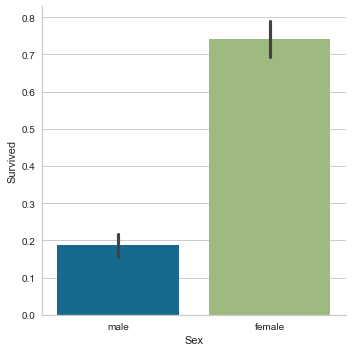

In [17]:
sns.catplot(x="Sex", y="Survived", data=titanic.data, kind='bar', orient='v')
titanic.get_target_correlation('Sex')

The plot above shows women aboard the Titanic had a higher survival rate than men.

### 3.6 What is the population distribution of male vs female?

male      577
female    314
Name: Sex, dtype: int64

male      0.647587
female    0.352413
Name: Sex, dtype: float64

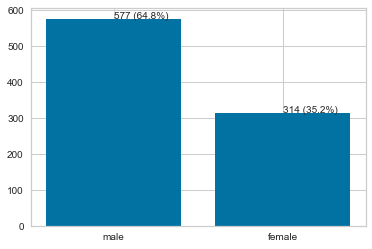

In [18]:
titanic.get_value_counts('Sex')
titanic.get_value_counts('Sex', normalize=True)
titanic.plot_value_counts('Sex')

We can see from this plot that there were about twice as many males as there were females on the Titanic.

### 3.2 What was the survival rate of children versus adults?

First, we need to create a flag indicating which passengers are above or below the age threshold.

In [19]:
titanic.data['Child'] = "adult"
titanic.data.loc[titanic.data['Age_Impute']<16, 'Child'] = "child"

Next, we will encode this new categorical variable.

In [20]:
titanic.encode_labels('Child')
titanic.data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_Code,Sex_Code,Title,Title_Code,Age_Impute,Embarked_Code_Impute,Child,Child_Code
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,1,Mr,11,22.0,2.0,adult,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,0,0,Mrs,12,38.0,0.0,adult,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2,0,Miss,8,26.0,2.0,adult,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,12,35.0,2.0,adult,0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,2,1,Mr,11,35.0,2.0,adult,0


,Child,Survived
0,adult,0.366625
1,child,0.520000


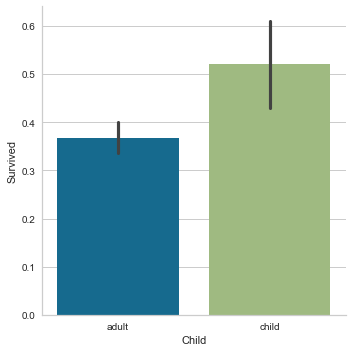

In [21]:
sns.catplot(x="Child", y="Survived", data=titanic.data, kind='bar', orient='v')
titanic.get_target_correlation('Child')

There doesn't appear to be as much of a disparity here as we saw previously with survival rates of men and women. A child's chance of surviving (regardless of sex) is not much better than flipping a coin.

### 3.7 What is the population distribution of children and adults?

adult    791
child    100
Name: Child, dtype: int64

adult    0.887767
child    0.112233
Name: Child, dtype: float64

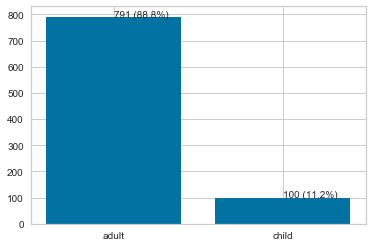

In [22]:
titanic.get_value_counts('Child')
titanic.get_value_counts('Child', normalize=True)
titanic.plot_value_counts('Child')

This plot shows that children made up a little more than 10% of the passengers aboard the Titanic.

### 3.5 What was surival rate of sex encoded with a child flag?

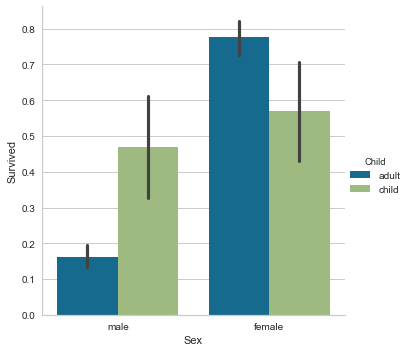

In [23]:
sns.catplot(x="Sex", y="Survived", hue="Child",data=titanic.data, kind='bar', orient='v')

The plot above shows that, despite low survival rate among men, male children enjoyed a marginally higher chance of survival. As we already observed in the previous plot, women, in general, had a much higher survival rate.

Therefore, women, regardless of their age had a higher chance of survival and male adults rarely made it out alive whereas male children had chances slightly less favorable than a coin flip.

### 3.3 Did passenger socio-economic status play a role in survival?

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


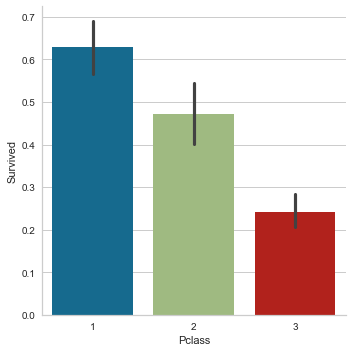

In [24]:
sns.catplot(x="Pclass", y="Survived",data=titanic.data, kind='bar', orient='v')
titanic.get_target_correlation('Pclass')

This plot shows that the higher the class of the passenger, the greater the likelihood of survival.

### 3.4 How does age affect a passengers survival?

First, we'll look at the distribution of Age (imputed).

###### * Bins are calculated using the [Freedman-Diaconis rule](https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule).
###### * Outliers are calculated using [Tukey's fences](https://en.wikipedia.org/wiki/Outlier#Tukey's_fences).

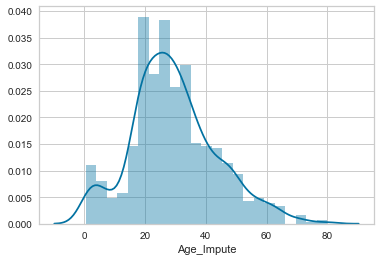

In [25]:
sns.distplot(titanic.data['Age_Impute'])

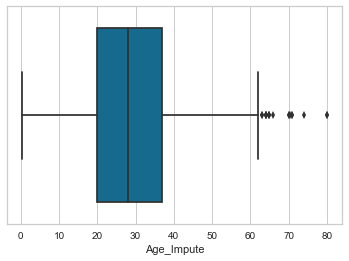

In [26]:
sns.boxplot(titanic.data['Age_Impute'])

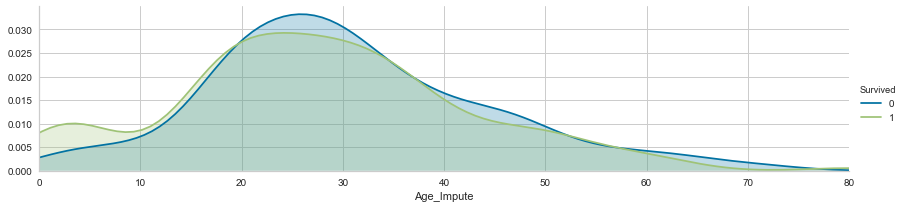

In [27]:
facet = sns.FacetGrid(titanic.data, hue="Survived", aspect=4)
facet.map(sns.kdeplot,'Age_Impute', shade=True)
facet.set(xlim=(0, titanic.data['Age_Impute'].max()))
facet.add_legend()

Text(0.5, 1.0, 'Sex and Age vs Survived')

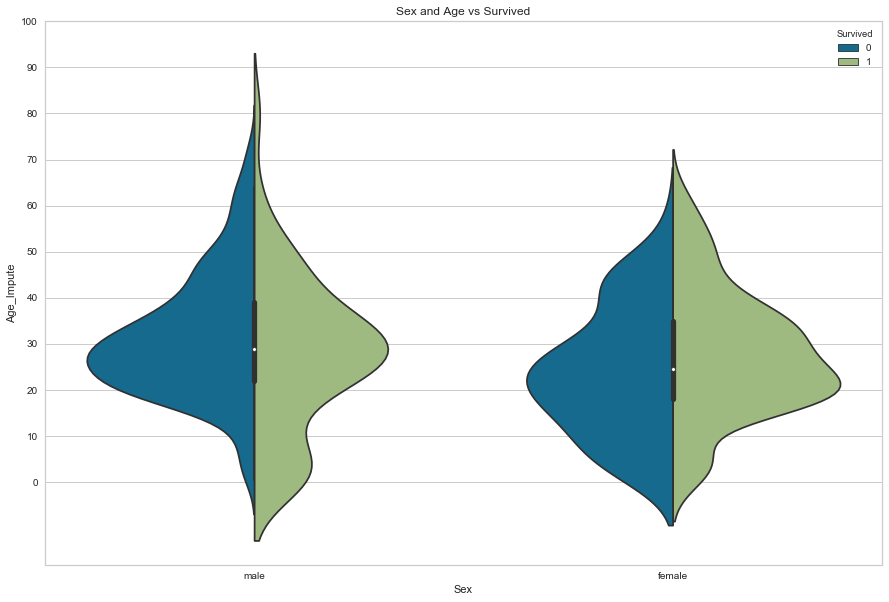

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.violinplot("Sex", "Age_Impute", hue="Survived", data=titanic.data, split=True, ax=ax)
ax.set_title('Sex and Age vs Survived')
ax.set_yticks(range(0, 110, 10))
plt.show()

There doesn't appear to be any relationship between Age and Survived except that passengers in their early 20s between late 30s had a good chance of surviving.

### 3.8 What is the correlation between each of our features versus the target?

Define a list of numeric features to be used in modeling.

In [29]:
numeric_features = [
    'Survived', 
    'Pclass', 
    'SibSp',
    'Parch', 
    'Fare', 
    'Sex_Code',
    'Title_Code', 
    'Age_Impute', 
    'Embarked_Code_Impute',
    'Child_Code'
]

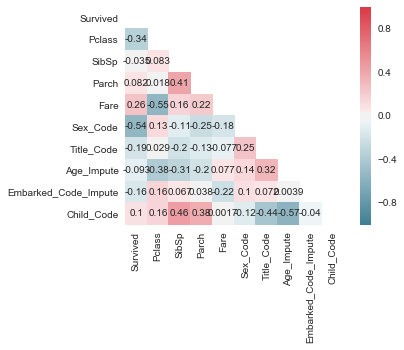

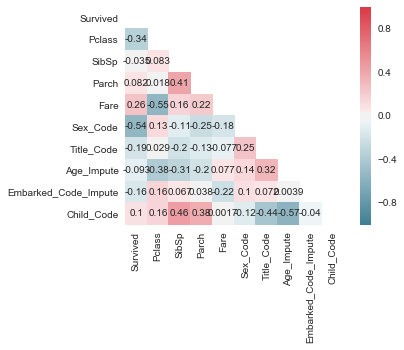

In [30]:
titanic.get_correlation_heatmap(columns=numeric_features)

Unfortunately, the results of our correlation matrix shows there is very little correlation (close to 0 or less than 50%) or they are about as good as flipping a coin. The plot above confirms this since we have a mix of categorical codes and continuous variables within our data set.

RadialVisualizer(alpha=1.0,
                 ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000155433B1DD8>,
                 classes=['died', 'survived'], colormap=None, colors=None,
                 features=['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare',
                           'Sex_Code', 'Title_Code', 'Age_Impute',
                           'Embarked_Code_Impute', 'Child_Code'])

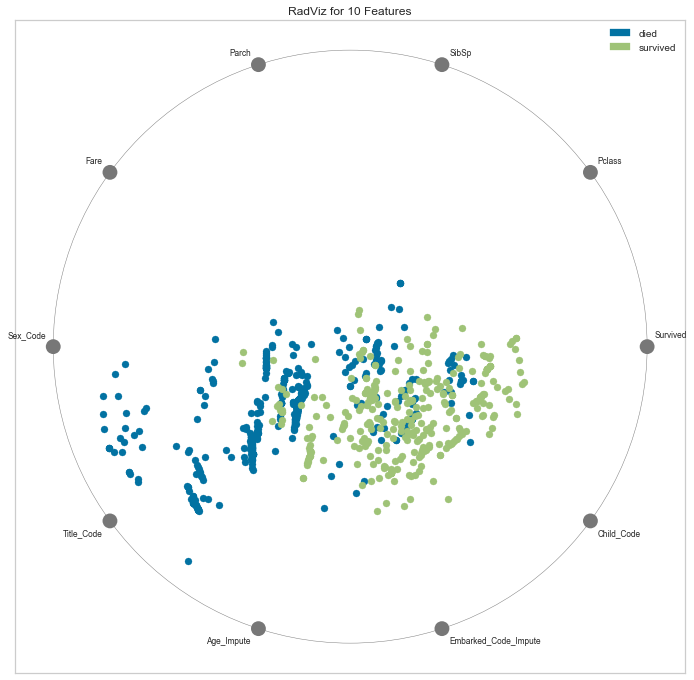

In [31]:
fig, ax = plt.subplots(figsize=(12, 12))
rv = RadViz(classes=['died', 'survived'], features=numeric_features)
rv.fit(titanic.data[numeric_features].values, titanic.data['Survived'].values)
_ = rv.transform(titanic.data[numeric_features])
rv.poof()

Next, we will loop through each predictor variable and print out a pivot of the survival rate.

In [32]:
for predictor in numeric_features:
    if predictor != 'Survived' and titanic.data[predictor].dtype != 'float64':
        predictor
        titanic.get_target_correlation(predictor)

'Pclass'

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


'SibSp'

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


'Parch'

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


'Sex_Code'

,Sex_Code,Survived
0,0,0.742038
1,1,0.188908


'Title_Code'

,Title_Code,Survived
0,0,0.000000
1,1,0.500000
2,2,0.000000
3,3,0.428571
4,4,0.000000
5,5,1.000000
6,6,0.500000
7,7,0.575000
8,8,0.697802
9,9,1.000000


'Child_Code'

,Child_Code,Survived
0,0,0.366625
1,1,0.520000
